In [1]:
#!pip install yellowbrick
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
import nltk
from nltk.tokenize import word_tokenize

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Sklearn clustering and encoding 
from sklearn.preprocessing import LabelEncoder


import cv2
from sklearn.manifold import TSNE
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.metrics import adjusted_rand_score
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.ticker import FuncFormatter
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

Num GPUs Available:  0


In [2]:
!python --version

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))



Python 3.11.5
pandas - 2.0.3
numpy - 1.26.3
seaborn - 0.12.2
nltk - 3.8.1
tensorflow - 2.12.0
tensorflow_hub - 0.15.0
cv2 - 4.8.1
gensim - 4.3.0


In [3]:
df=  pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
df.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [5]:
df.sample(5)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
371,2a20862f02555a44b0ab301bed987a0b,2015-12-01 06:13:00 +0000,http://www.flipkart.com/netgear-jwnr2010-n300-...,Netgear JWNR2010 N300 Wireless Router,"[""Computers >> Network Components >> Routers >...",RTRDPXKCBHEECZQE,2500.0,1367.0,2a20862f02555a44b0ab301bed987a0b.jpg,True,Buy Netgear JWNR2010 N300 Wireless Router only...,3.9,3.9,Netgear,"{""product_specification""=>[{""key""=>""Firewall"",..."
966,378d7dbdb97ecc62c9ad52cb6df23a86,2016-06-15 19:32:11 +0000,http://www.flipkart.com/checkered-chef-steel-a...,Checkered Chef Steel All-Purpose Scissor,"[""Kitchen & Dining >> Kitchen Tools >> Kitchen...",KISEJ7WDQY499TQE,2260.0,1921.0,378d7dbdb97ecc62c9ad52cb6df23a86.jpg,False,"Checkered Chef Steel All-Purpose Scissor (Red,...",No rating available,No rating available,Checkered Chef,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
668,3f025b9dc8065fe5a155573e5b21a70d,2015-12-31 09:19:31 +0000,http://www.flipkart.com/ornate-7-w-led-bulb/p/...,Ornate 7 W LED Bulb,"[""Kitchen & Dining >> Lighting >> Bulbs >> Orn...",BLBECSRFVRR7XCZH,375.0,209.0,3f025b9dc8065fe5a155573e5b21a70d.jpg,False,Buy Ornate 7 W LED Bulb for Rs.209 online. Orn...,5,5,Ornate,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
456,8ec6ee9814a27423e66c3c9ea26f77aa,2015-12-03 21:49:05 +0000,http://www.flipkart.com/scalabedding-cotton-st...,Scalabedding Cotton Striped King sized Double ...,"[""Home Furnishing >> Bed Linen >> Bedsheets""]",BDSE7FQ52B4P2Y6G,2585.0,2115.0,8ec6ee9814a27423e66c3c9ea26f77aa.jpg,False,Buy Scalabedding Cotton Striped King sized Dou...,No rating available,No rating available,Scalabedding,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1038,7821fb1cbf8d3bb294c3c20527119f15,2016-03-03 06:06:42 +0000,http://www.flipkart.com/surgical-e-sstudio-s00...,"Surgical e Sstudio S0004 Gown, Pant Hospital S...","[""Beauty and Personal Care >> Health Care >> M...",HTSEG6YUAFSNFG6M,2500.0,1650.0,7821fb1cbf8d3bb294c3c20527119f15.jpg,False,"Key Features of Surgical e Sstudio S0004 Gown,...",No rating available,No rating available,Surgical e Sstudio,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


In [6]:
df.dtypes.value_counts()

object     12
float64     2
bool        1
Name: count, dtype: int64

In [7]:
df.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

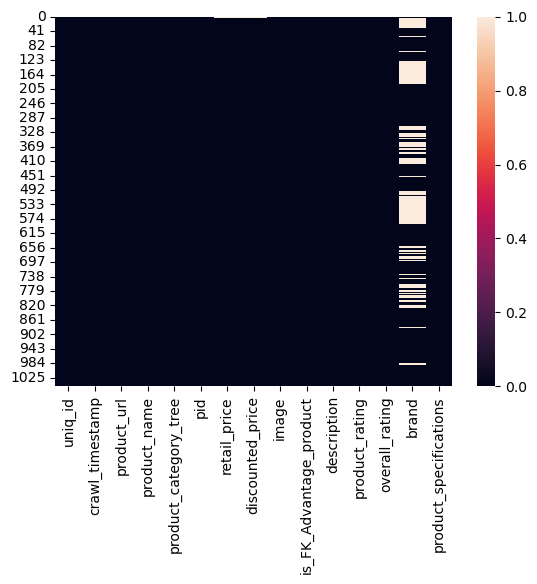

In [8]:
sns.heatmap(df.isnull());

### Traitement de la fonctionnalité "product_category_tree"

In [9]:
df.duplicated(subset="product_category_tree").sum()

408

In [10]:
df_cat = df.groupby('product_category_tree')
df_cat.first()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
product_category_tree,,,,,,,,,,,,,,
"[""Baby Care >> Baby & Kids Gifts >> Decorations >> Doraemon Gift Family Ceramic Coffee Mug Decorations >> Doraemon Gift Family Ceramic Coffee Mug Multicol...""]",6325bf868b9040a0599f257aba42e9e0,2016-03-03 11:29:08 +0000,http://www.flipkart.com/doraemon-gift-family-c...,Doraemon Gift Family Ceramic Coffee Mug Multic...,DECEG7K7Y3URGWXH,399.0,280.0,6325bf868b9040a0599f257aba42e9e0.jpg,False,Specifications of Doraemon Gift Family Ceramic...,No rating available,No rating available,Doraemon Gift Family Ceramic Coffee Mug,"{""product_specification""=>[{""key""=>""Sales Pack..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Cocovey Photo Frames""]",fd10586bf7f01bc57e0c5364d4b2c3f7,2015-12-31 09:19:31 +0000,http://www.flipkart.com/cocovey-metal-photo-fr...,Cocovey Metal Photo Frame,PHFEBZ2GBSK3U43Z,749.0,549.0,fd10586bf7f01bc57e0c5364d4b2c3f7.jpg,False,"Cocovey Metal Photo Frame (Photo Size - 6*4, 1...",No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Indha Craft Photo Frames""]",6eabdbbbffdfae86c3c5177ba0f96ea7,2015-12-31 09:19:31 +0000,http://www.flipkart.com/indha-craft-cloth-phot...,Indha Craft Cloth Photo Frame,PHFDWUHW25WAWXHY,300.0,132.0,6eabdbbbffdfae86c3c5177ba0f96ea7.jpg,False,Indha Craft Cloth Photo Frame (Photo Size - 12...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> MH Photo Frames""]",d06bb04b096c77dc3302eaf2db336f96,2015-12-31 09:19:31 +0000,http://www.flipkart.com/mh-mdf-photo-frame/p/i...,MH MDF Photo Frame,PHFEE9ZQGBXX5NYY,999.0,899.0,d06bb04b096c77dc3302eaf2db336f96.jpg,False,Buy MH MDF Photo Frame for Rs.899 online. MH M...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Stand Mate..."
"[""Baby Care >> Baby & Kids Gifts >> Photo Frames >> Wood Beauty Photo Frames""]",f79c9db3abd7faca714c92aeba9b6728,2015-12-31 09:19:31 +0000,http://www.flipkart.com/wood-beauty-photo-fram...,Wood Beauty Wood Photo Frame,PHFEEDJREU4HHEJG,650.0,450.0,f79c9db3abd7faca714c92aeba9b6728.jpg,False,Buy Wood Beauty Wood Photo Frame for Rs.450 on...,No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Frame Mate..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[""Watches >> Wrist Watches >> Yves Bertelin Wrist Watches >> Yves Bertelin YBSCR557 Analog Watch - For Women""]",4d2e9f36823bad0f6fe8c6b19bb92bdb,2016-04-24 18:34:50 +0000,http://www.flipkart.com/yves-bertelin-ybscr557...,Yves Bertelin YBSCR557 Analog Watch - For Women,WATEHYHJZDVZXNHZ,6950.0,3475.0,4d2e9f36823bad0f6fe8c6b19bb92bdb.jpg,False,Specifications of Yves Bertelin YBSCR557 Analo...,No rating available,No rating available,Yves Bertelin,"{""product_specification""=>[{""key""=>""Mechanism""..."
"[""Watches >> Wrist Watches >> fastrack Wrist Watches""]",653826cd53f1d9e2c086c0ac7846ef70,2015-12-04 07:25:36 +0000,http://www.flipkart.com/fastrack-38015pl01-ana...,"fastrack 38015PL01 Analog Watch - For Men, Boys",WATE9WKSHRYTM2PP,2495.0,2495.0,653826cd53f1d9e2c086c0ac7846ef70.jpg,False,"fastrack 38015PL01 Analog Watch - For Men, Bo...",No rating available,No rating available,None,"{""product_specification""=>[{""key""=>""Chronograp..."
"[""Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 149 Analog Watch - For Girls, Women""]",64a9d0488652194fd8e879d5e6dc8015,2016-04-24 18:34:50 +0000,http://www.flipkart.com/palito-plo-149-analog-...,"palito PLO 149 Analog Watch - For Girls, Women",WATEHZP3ZA9YT99G,1500.0,199.0,64a9d0488652194fd8e879d5e6dc8015.jpg,False,Specifications of palito PLO 149 Analog Watch ...,No rating available,No rating available

In [11]:
#Diviser le contenu de la colonne sur '>>' et récupérer le premier élément = la catégorie principale du produit
df['category'] = df['product_category_tree'].str.split('>>').str.get(0).str.strip()

# Suppression de la ponctuation indésirable de la colonne de catégorie
df['category'] = df['category'].str.extract(r'^\["([^"]+)')

In [12]:
# Real number of product categories 
category_count = df['category'].value_counts()

In [13]:
category_count 

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

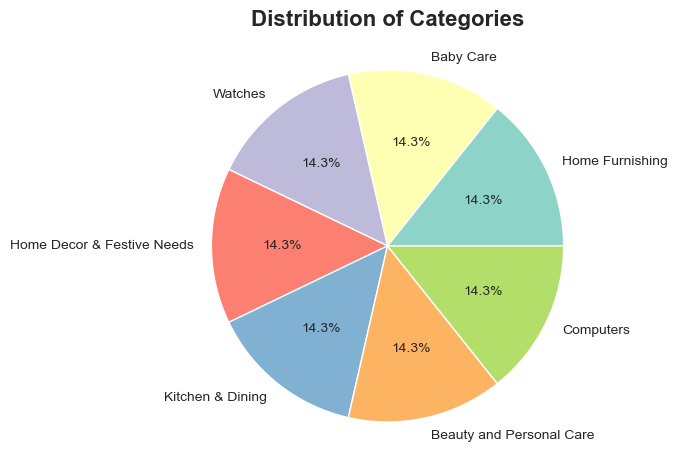

In [14]:
# La distribution par categorie
custom_colors = sns.color_palette('Set3', len(category_count))
plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%', colors=custom_colors)
plt.title('Distribution of Categories',  fontsize=16, fontweight='bold', pad=20)
plt.axis('equal') 

plt.show()

Il y a sept grandes catégories de produits

## Pre traitement

## Exploration des données


In [15]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wall

In [16]:
df_t = df 
df_t.shape

(1050, 16)

In [17]:
df.description.apply(lambda i : len(i))

0       1420
1        444
2       1258
3        858
4       1197
        ... 
1045    2432
1046    1660
1047     262
1048     210
1049     187
Name: description, Length: 1050, dtype: int64

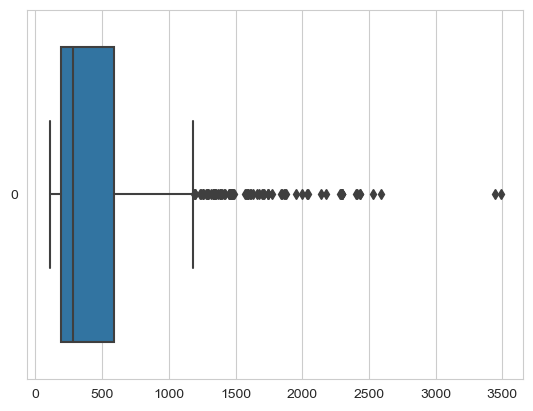

In [18]:
tmp = df.description.str.len()
sns.boxplot(tmp, orient='h');

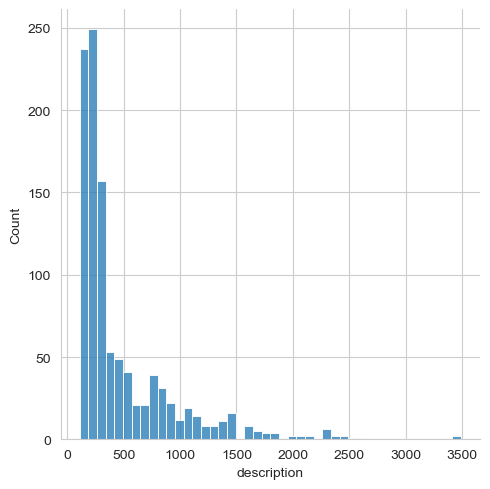

In [19]:
sns.displot(tmp);

In [20]:
df_long = df["_lon_desc"] = tmp
df_long.head(10)

0    1420
1     444
2    1258
3     858
4    1197
5     275
6     268
7     817
8     410
9     430
Name: description, dtype: int64

### Exploration du corpus et des documents

In [21]:
df.head(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,1258
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,858
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1197
5,893aa5ed55f7cff2eccea7758d7a86bd,2015-12-04 07:25:36 +0000,http://www.flipkart.com/maserati-time-r8851116...,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",WATEAYAHJ8CUCAYM,24400.0,24400.0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,False,Maserati Time R8851116001 Analog Watch - For ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,275
6,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04 07:25:36 +0000,http://www.flipkart.com/camerii-wm64-elegance-...,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",WATE6Y6D2MZHWGBZ,1099.0,449.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,False,"Camerii WM64 Elegance Analog Watch - For Men,...",5,5,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,268
7,dd0e3470a7e6ed76fd69c2da27721041,2015-12-04 07:25:36 +0000,http://www.flipkart.com/t-star-uft-tsw-005-bk-...,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",WATECFFVGFZPAD3D,999.0,399.0,dd0e3470a7e6ed76fd69c2da27721041.jpg,False,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,817
8,41384da51732c0b4df3de8f395714fbb,2015-12-04 07:25:36 +0000,http://www.flipkart.com/alfajr-wy16b-youth-dig...,"Alfajr WY16B Youth Digital Watch - For Men, Boys","[""Watches >

In [22]:
df_samp = df.sample(10)
df_samp

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
549,8a15fa23b8c39ac1c7eaac94cbbe6fc6,2016-01-07 05:50:25 +0000,http://www.flipkart.com/hmt-s3648-analog-watch...,HMT S3648 Analog Watch - For Men,"[""Watches >> Wrist Watches >> HMT Wrist Watches""]",WATDYQ93UUZYVFQX,800.0,800.0,8a15fa23b8c39ac1c7eaac94cbbe6fc6.jpg,True,HMT S3648 Analog Watch - For Men - Buy HMT S3...,3.7,3.7,NaN,"{""product_specification""=>[{""key""=>""Mechanism""...",Watches,315
621,46ca672fdfff8a1b3641642a9795344a,2016-03-16 23:37:14 +0000,http://www.flipkart.com/you-got-plan-b-baby-bo...,"You Got Plan B Baby Boy's, Baby Girl's Romper","[""Baby Care >> Infant Wear >> Baby Boys' Cloth...",BOLEGTGHZXZM3HHG,449.0,449.0,46ca672fdfff8a1b3641642a9795344a.jpg,False,"Key Features of You Got Plan B Baby Boy's, Bab...",No rating available,No rating available,You Got Plan B,"{""product_specification""=>[{""key""=>""Length"", ""...",Baby Care,603
555,51c9062e6538c787b14a75a6a7cb7fb3,2016-01-07 05:50:25 +0000,http://www.flipkart.com/sonata-7007sl02-analog...,Sonata 7007SL02 Analog Watch - For Men,"[""Watches >> Wrist Watches >> Sonata Wrist Wat...",WATDWGAHRCPFYWGW,725.0,725.0,51c9062e6538c787b14a75a6a7cb7fb3.jpg,True,Sonata 7007SL02 Analog Watch - For Men - Buy ...,3.5,3.5,NaN,"{""product_specification""=>[{""key""=>""Mechanism""...",Watches,309
879,fc976caafdebbab15560dad48bc6ff0f,2015-12-20 08:26:17 +0000,http://www.flipkart.com/casa-copenhagen-set-to...,Casa Copenhagen Set of Towels,"[""Home Furnishing >> Bath Linen >> Towels""]",BTWE4GQS9TZHKHY4,800.0,800.0,fc976caafdebbab15560dad48bc6ff0f.jpg,False,Buy Casa Copenhagen Set of Towels at Rs. 800 a...,No rating available,No rating available,Casa Copenhagen,"{""product_specification""=>[{""key""=>""Design"", ""...",Home Furnishing,117
49,02a53d335775b652f22f41b529b9d646,2016-03-20 14:44:44 +0000,http://www.flipkart.com/suave-naturals-everlas...,Suave Naturals Everlasting Sunshine Conditioner,"[""Beauty and Personal Care >> Hair Care >> Con...",CNDEGVE6PR98MZHU,2300.0,1126.0,02a53d335775b652f22f41b529b9d646.jpg,False,Key Features of Suave Naturals Everlasting Sun...,No rating available,No rating available,Suave,"{""product_specification""=>[{""key""=>""Hair Condi...",Beauty and Personal Care,470
823,697ad1d2e45c1af54cab7847cbe324d8,2015-12-31 17:07:54 +0000,http://www.flipkart.com/firstrace-101-107-anal...,Firstrace 101-107 Analog Watch - For Couple,"[""Watches >> Wrist Watches >> Firstrace Wrist ...",WATEDHWY6UYHX6ZR,2899.0,899.0,697ad1d2e45c1af54cab7847cbe324d8.jpg,False,Firstrace 101-107 Analog Watch - For Couple -...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va...",Watches,257
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-s...,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2ZEPACRQJKH7,1190.0,595.0,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Pack...",Baby Care,187
962,8ff973688c976a08fc7242da37101417,2016-03-18 08:01:41 +0000,http://www.flipkart.com/furnishingland-black-p...,FURNISHINGLAND Black Polyester Carpet,"[""Home Furnishing >> Floor Coverings >> Carpet...",CPGEGUDYCKYNUR2M,2650.0,1325.0,8ff973688c976a08fc7242da37101417.jpg,False,Key Features of FURNISHINGLAND Black Polyester...,No rating available,No rating available,FURNISHINGLAND,"{""product_specification""=>[{""key""=>""Shape"", ""v...",Home Furnishing,978
368,f386f28cbc2ca9a63b5dc7a8fe6d5098,2015-12-01 06:13:00 +0000,http://www.flipkart.com/denver-caliber-pride-c...,"Denver Caliber,Pride Combo Set","[""Beauty and Personal Care >> Fragrances >> De...",CAGEBTJBTZ9HK4AU,409.0,370.0,f386f28cbc2ca9a63b5dc7a8fe6d5098.jpg,False

In [23]:
for idx, ser in df_samp.iterrows():
    id_prod = f": {ser['uniq_id']}\n"
    print( id_prod + ser["description"]+ "..." +"\n\n")

: 8a15fa23b8c39ac1c7eaac94cbbe6fc6
HMT S3648 Analog Watch  - For Men - Buy HMT S3648 Analog Watch  - For Men  S3648 Online at Rs.800 in India Only at Flipkart.com. Round Dial, Brown Strap, Stainless Steel Back Case, Water Resistant, Buckle Clasp - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!...


: 46ca672fdfff8a1b3641642a9795344a
Key Features of You Got Plan B Baby Boy's, Baby Girl's Romper Fabric: Cotton Brand Color: Orange,You Got Plan B Baby Boy's, Baby Girl's Romper Price: Rs. 449 For the much awaited and confident baby. He/ she knows everyones been waiting for him and he's raring to go! Made with 100% cotton,Specifications of You Got Plan B Baby Boy's, Baby Girl's Romper Dimensions Length 16 inch General Details Age Group 3 -  12 month Fabric Cotton Pattern Solid Ideal For Baby Boy's, Baby Girl's Fabric Care Machine wash with warm water. Do not tumble dry. No bleach. Warm ironing. Wash and dry dark colours seperately...




In [24]:
df_samp0 = df.sample(10)
df_samp0

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,_lon_desc
667,5eec66ec172ce096cd4e5c947686b56a,2015-12-31 09:19:31 +0000,http://www.flipkart.com/rtd-baby-girl-s-kurta-...,RTD Baby Girl's Kurta and Pyjama Set,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",ETHECM6WDWQATHHH,1183.0,599.0,5eec66ec172ce096cd4e5c947686b56a.jpg,False,RTD Baby Girl's Kurta and Pyjama Set - Buy Yel...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Sleeve"", ""...",Baby Care,203
1023,b7214d4c357e3f7acae72fcbe7d31afe,2016-03-03 06:06:42 +0000,http://www.flipkart.com/transcend-premium-memo...,Transcend Premium Memory DDR2 2 GB (1x2GB) PC ...,"[""Computers >> Computer Components >> RAMs >> ...",RAMEGFGCHMH8AN8W,2999.0,1248.0,b7214d4c357e3f7acae72fcbe7d31afe.jpg,False,Specifications of Transcend Premium Memory DDR...,4.2,4.2,Transcend,"{""product_specification""=>[{""key""=>""Sales Pack...",Computers,556
752,83cef279f0ea5d772523d0d8b2923fbe,2015-12-12 11:46:53 +0000,http://www.flipkart.com/rajasthan-crafts-abstr...,Rajasthan Crafts Abstract Single Quilts & Comf...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",BLAE8YHUBQ8BXRZG,950.0,840.0,83cef279f0ea5d772523d0d8b2923fbe.jpg,False,Buy Rajasthan Crafts Abstract Single Quilts & ...,No rating available,No rating available,Rajasthan Crafts,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,146
1013,b48218a94e220c20373ed50dc4254093,2016-03-02 19:09:22 +0000,http://www.flipkart.com/lawman-pg3-striker-win...,"LAWMAN PG3 Striker,, Winger , Contender Deodor...","[""Beauty and Personal Care >> Fragrances >> De...",DEOEG9GYD746P2DH,597.0,447.0,b48218a94e220c20373ed50dc4254093.jpg,False,"Key Features of LAWMAN PG3 Striker,, Winger , ...",No rating available,No rating available,LAWMAN PG3,"{""product_specification""=>[{""key""=>""Fragrance ...",Beauty and Personal Care,454
678,22ac36ba254a68d7dd6173f099771147,2015-12-31 09:19:31 +0000,http://www.flipkart.com/neyth-cotton-set-towel...,Neyth Cotton Set of Towels,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEDRTHRY83HXYY,300.0,170.0,22ac36ba254a68d7dd6173f099771147.jpg,False,Buy Neyth Cotton Set of Towels at Rs. 170 at F...,No rating available,No rating available,Neyth,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,114
431,281dfd9b94b34362c295b3e5f8da5dfa,2016-03-11 06:55:07 +0000,http://www.flipkart.com/smartpro-19-5v-3-9a-re...,"Smartpro 19.5v,3.9a Replacement Charger for Va...","[""Computers >> Laptop Accessories >> Adapters ...",ACCEGZ6BS9JKBF5P,1499.0,539.0,281dfd9b94b34362c295b3e5f8da5dfa.jpg,False,"Specifications of Smartpro 19.5v,3.9a Replacem...",No rating available,No rating available,Smartpro,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Computers,1065
664,c9c4720bca91b8ce27d8190a7c4c139c,2015-12-31 09:19:31 +0000,http://www.flipkart.com/blue-bell-popfun-sippe...,Blue Bell Popfun Sipper,"[""Baby Care >> Feeding & Nursing >> Utensils >...",SICDBJVHQ3DJRGM9,280.0,180.0,c9c4720bca91b8ce27d8190a7c4c139c.jpg,False,Buy Blue Bell Popfun Sipper for Rs.180 online....,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Age Group""...",Baby Care,177
917,27175ea71cc5f2879882c77b9931cf8b,2016-01-01 13:15:34 +0000,http://www.flipkart.com/megaway-196-85-inch-wh...,Megaway 196.85 inch White Rice Lights,"[""Home Decor & Festive Needs >> Decorative Lig...",RCLE3KUDBPC6UGPW,7000.0,4050.0,27175ea71cc5f2879882c77b9931cf8b.jpg,False,Megaway 196.85 inch White Rice Lights (Pack of...,No rating available,No rating available,Megaway,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Decor & Festive Needs,401
145,60efd61370e70267dc60b11ff2bf974c,2015-12-01 12:40:44 +0000,http://www.flipkart.com/prithish-abstract-desi...,Prithish Abstract Design 40 Ceramic Mug,"

### Nettoyage de la fonctionalité "description"
### Bag of word

In [25]:
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
df_t["cleaned_description"]=df_t["description"].apply(cleaned_text)

In [27]:
df_t["cleaned_description"] = df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [28]:
 df_t["cleaned_description"].head(10)

0    features elegance polyester multicolor abstrac...
1    specifications sathiyas cotton bath towel bath...
2    features eurospa cotton terry face towel size ...
3    features santosh royal fashion cotton printed ...
4    features jaipur print cotton floral king sized...
5    maserati time analog watch boys maserati time ...
6    camerii elegance analog watch boys camerii ele...
7    star analog watch boys price whether your work...
8    alfajr youth digital watch boys alfajr youth d...
9    heuer formula analog watch boys heuer formula ...
Name: cleaned_description, dtype: object

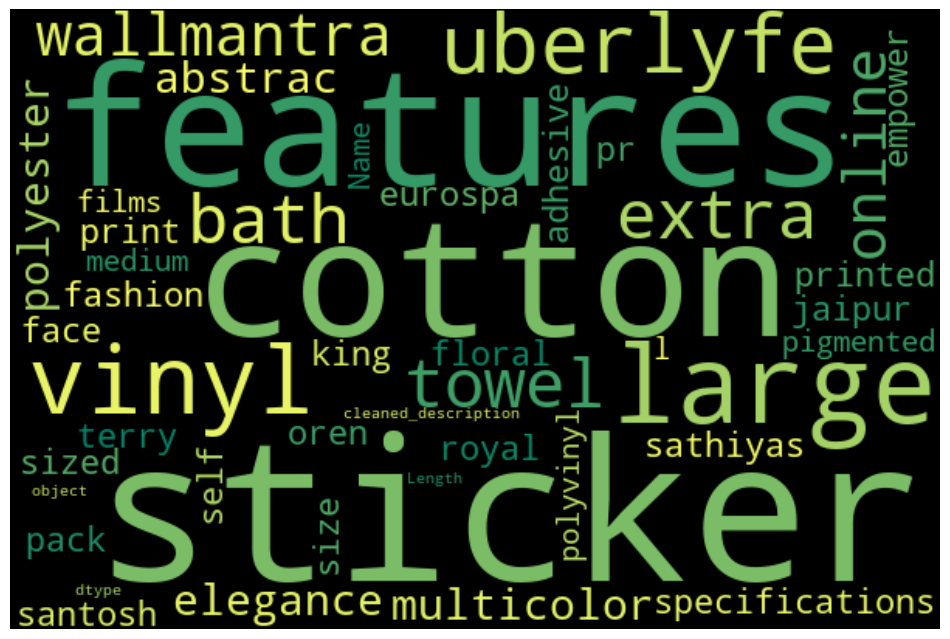

In [29]:
cloud=WordCloud(colormap="summer",width=600,height=400).generate(str(df_t["cleaned_description"]))
fig=plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear');

In [30]:
stop=stopwords.words('english')
stop.append("also")
df_t["stop_removed_description"]=df_t["cleaned_description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [31]:
df_t["tokenized"]=df_t["stop_removed_description"].apply(lambda x: nltk.word_tokenize(x))

In [32]:
df_t["tokenized"]

0       [features, elegance, polyester, multicolor, ab...
1       [specifications, sathiyas, cotton, bath, towel...
2       [features, eurospa, cotton, terry, face, towel...
3       [features, santosh, royal, fashion, cotton, pr...
4       [features, jaipur, print, cotton, floral, king...
                              ...                        
1045    [oren, empower, extra, large, self, adhesive, ...
1046    [wallmantra, large, vinyl, sticker, sticker, p...
1047    [uberlyfe, extra, large, pigmented, polyvinyl,...
1048    [wallmantra, medium, vinyl, sticker, sticker, ...
1049    [uberlyfe, large, vinyl, sticker, online, uber...
Name: tokenized, Length: 1050, dtype: object

### Lemmatization

In [33]:
from nltk.stem import WordNetLemmatizer 

In [34]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df_t["lemmatized"]=df_t["tokenized"].apply(lambda x: word_lemmatizer(x))
df_t["lemmatize_joined"]=df_t["lemmatized"].apply(lambda x: ' '.join(x))

In [35]:
df_t["lemmatize_joined"].head()

0    feature elegance polyester multicolor abstract...
1    specifications sathiyas cotton bath towel bath...
2    feature eurospa cotton terry face towel size s...
3    feature santosh royal fashion cotton print kin...
4    feature jaipur print cotton floral king size d...
Name: lemmatize_joined, dtype: object

In [36]:
df_t['Nombre de mots après nettoyage'] = df_t['lemmatize_joined'].apply(lambda x:len(str(x).split()))

In [37]:
df_t

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,brand,product_specifications,category,_lon_desc,cleaned_description,stop_removed_description,tokenized,lemmatized,lemmatize_joined,Nombre de mots après nettoyage
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,1420,features elegance polyester multicolor abstrac...,features elegance polyester multicolor abstrac...,"[features, elegance, polyester, multicolor, ab...","[feature, elegance, polyester, multicolor, abs...",feature elegance polyester multicolor abstract...,141
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,444,specifications sathiyas cotton bath towel bath...,specifications sathiyas cotton bath towel bath...,"[specifications, sathiyas, cotton, bath, towel...","[specifications, sathiyas, cotton, bath, towel...",specifications sathiyas cotton bath towel bath...,55
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,1258,features eurospa cotton terry face towel size ...,features eurospa cotton terry face towel size ...,"[features, eurospa, cotton, terry, face, towel...","[feature, eurospa, cotton, terry, face, towel,...",feature eurospa cotton terry face towel size s...,131
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,858,features santosh royal fashion cotton printed ...,features santosh royal fashion cotton printed ...,"[features, santosh, royal, fashion, cotton, pr...","[feature, santosh, royal, fashion, cotton, pri...",feature santosh royal fashion cotton print kin...,102
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,1197,features jaipur print cotton floral king sized...,features jaipur print cotton floral king sized...,"[features, jaipur, print, cotton, floral, king...","[feature, jaipur, print, cotton, floral, king,...",feature jaipur print cotton floral king size d...,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,2432,oren empower extra large self adhesive sticker...,oren empower extra large self adhesive s

In [38]:
df_t.to_csv('df_t.csv', index=False)

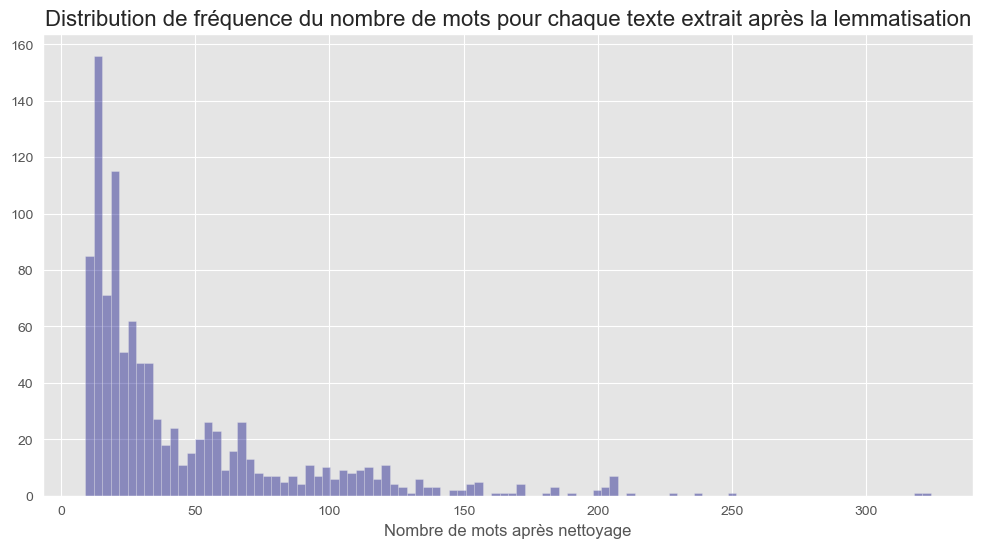

In [39]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "navy", bins = 100)
plt.title("Distribution de fréquence du nombre de mots pour chaque texte extrait après la lemmatisation", size=16);

In [40]:
df_t.drop(df_t[df_t["Nombre de mots après nettoyage"]>300].index, inplace = True)

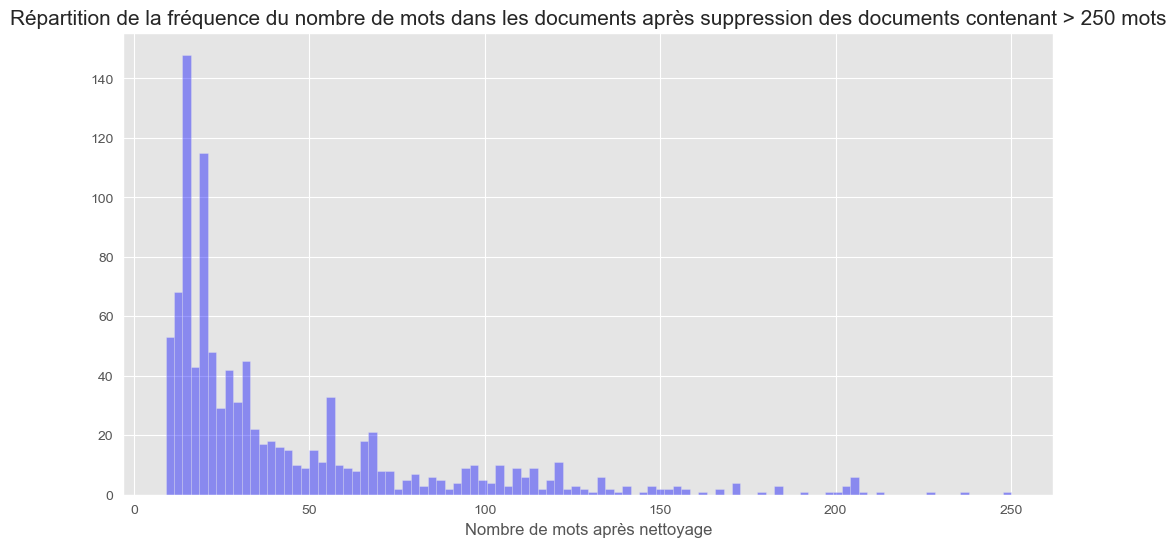

In [41]:
plt.style.use('ggplot')
plt.figure(figsize=(12,6))
sns.distplot(df_t['Nombre de mots après nettoyage'],kde = False, color= "blue", bins = 100)
plt.title("Répartition de la fréquence du nombre de mots dans les documents après suppression des documents contenant > 250 mots", size=15);

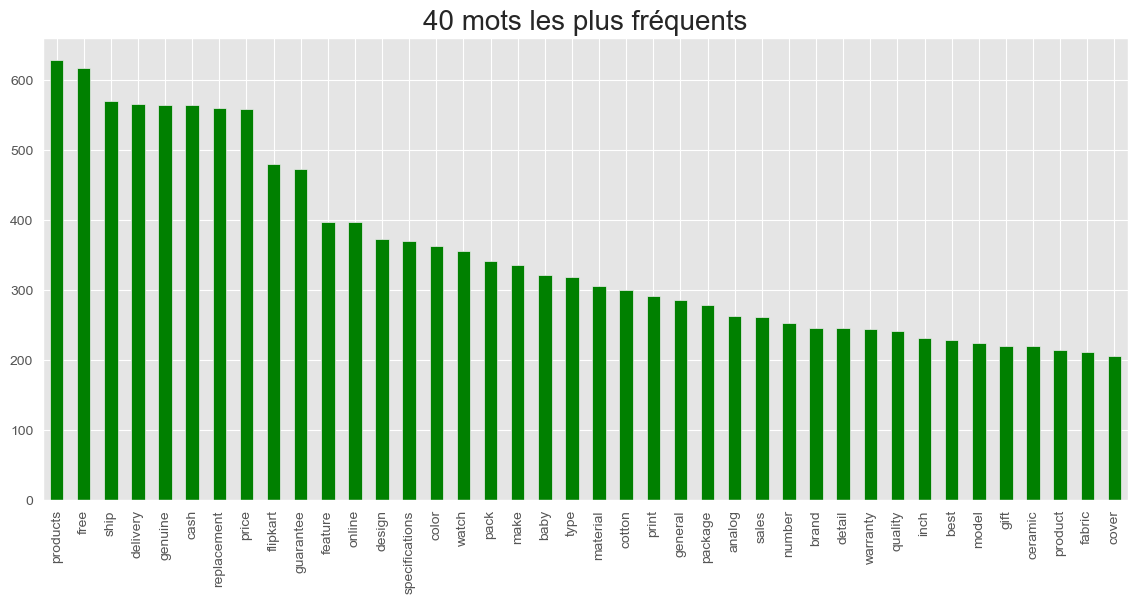

In [42]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
freq=pd.Series(" ".join(df_t["lemmatize_joined"]).split()).value_counts()[:40]
freq.plot(kind="bar", color = "green")
plt.title("40 mots les plus fréquents",size=20);

## NLP   
### TF-IDF (Term frequency-inverse document frequency)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizer, BertModel
from gensim.models import Word2Vec
import itertools
import tensorflow as tf


In [44]:
from string import punctuation
from nltk.corpus import stopwords
stopwords_en = set(["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"])
stopwords_nltk = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stopwords_combined = set.union(stopwords_en, stopwords_nltk, stopwords_punct)

In [45]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
     def __init__(self):
         self.wnl = WordNetLemmatizer()
        
     def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

tfidf = TfidfVectorizer(encoding='utf-8',
                       lowercase=True,
                       tokenizer=LemmaTokenizer(),
                       stop_words=stopwords_combined,
                       )

In [46]:
tfidf = TfidfVectorizer()
 
# get tf-df values
result = tfidf.fit_transform(df_t["description"])

In [47]:
# display tf-idf values
print('\ntf-idf value:')
print(result)


tf-idf value:
  (0, 3574)	0.02435118531699746
  (0, 2012)	0.028231536843717507
  (0, 1279)	0.03463120725266925
  (0, 4047)	0.047392208123346664
  (0, 4765)	0.047392208123346664
  (0, 1769)	0.027631362017021478
  (0, 3909)	0.02378080899306603
  (0, 1317)	0.0225107899230491
  (0, 3371)	0.034095824079673556
  (0, 2063)	0.027503127000571684
  (0, 1664)	0.02382345467055865
  (0, 2180)	0.06705250833395213
  (0, 3015)	0.0364533820607544
  (0, 4871)	0.026594252177580834
  (0, 3818)	0.031214911825098335
  (0, 3694)	0.05462810674834151
  (0, 5598)	0.02348768047602811
  (0, 2577)	0.011827470124136853
  (0, 2013)	0.0364533820607544
  (0, 1330)	0.024261108770697478
  (0, 2692)	0.0213290503952278
  (0, 5120)	0.019910474036639328
  (0, 5283)	0.06705250833395213
  (0, 916)	0.06065283792500038
  (0, 4661)	0.0484493666071762
  :	:
  (1047, 5603)	0.5643396287255084
  (1047, 5728)	0.400359677351323
  (1047, 5190)	0.400359677351323
  (1047, 3328)	0.42656889073766247
  (1047, 4353)	0.108132476015503
  (104

In [48]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(df_t["lemmatize_joined"])
final_tf_idf.shape

(1048, 3986)

In [49]:
final_tf_idf

<1048x3986 sparse matrix of type '<class 'numpy.float64'>'
	with 29004 stored elements in Compressed Sparse Row format>

In [50]:
finalScore = df_t['category']
finalScore

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: category, Length: 1048, dtype: object

In [51]:
# Converting each sequence of words into a single string
corpus = df_t['lemmatize_joined']

# Defining the vectorizer
vectorizer = TfidfVectorizer()

# Fitting it to the string 
vectorizer.fit(corpus)

# Transforming the corpus into a TF-IDF matrix
tfidf_matrix = vectorizer.transform(corpus)

# Converting the TF-IDF matrix to a df
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [52]:
df_tfidf

,aapno,aari,aarika,abide,abilities,ability,abkl,able,abroad,absolute,...,zero,zikrak,zinc,zingalalaa,zipexterior,zipper,zone,zoom,zora,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Dimensional reduction
from sklearn.decomposition import PCA

In [54]:
# Defining the PCA
n_components = 2
pca = PCA(n_components=n_components)

# Fitting to the df_tfidf
pca_result = pca.fit_transform(df_tfidf)

# New df for the results 
df_pca = pd.DataFrame(data=pca_result, columns=["PC{}".format(i+1) for i in range(n_components)])

In [55]:
df_pca

,PC1,PC2
0,-0.201816,-0.013014
1,-0.188942,-0.006650
2,-0.189502,-0.009588
3,-0.217457,0.002019
4,-0.230630,-0.007384
...,...,...
1043,-0.138621,0.002574
1044,-0.174679,-0.000898
1045,-0.018493,-0.042745
1046,0.007900,-0.063302


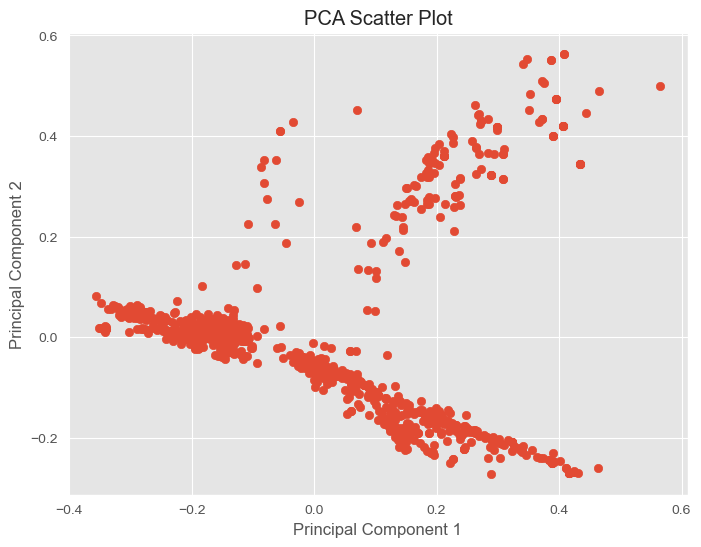

In [56]:
# Plot 
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()

### t-SNE visualization for TF-IDF

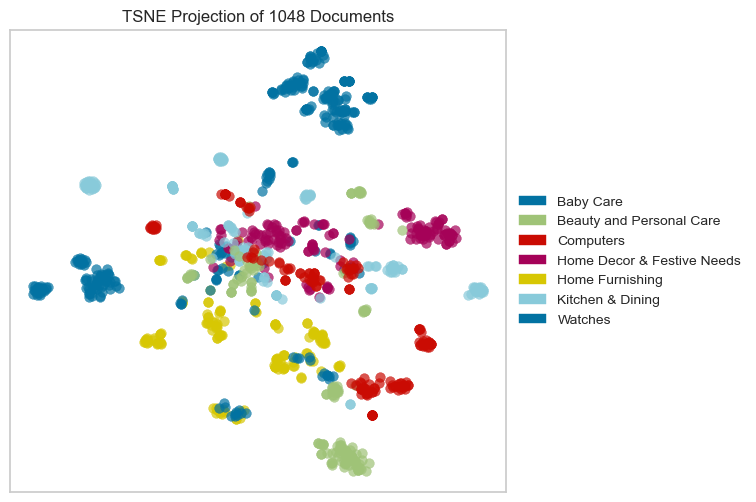

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer


# Load the data and create document vectors
corpus = df_t.lemmatize_joined
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus)
y = df_t.category

# Create the visualizer and draw the vectors
plt.figure(figsize=(8, 6))
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show();

### Kmeans clustering et représentation visuelle du t-SNE avec TF-ID

In [58]:
from sklearn.cluster import KMeans

In [59]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_t.lemmatize_joined)

In [60]:
num_clusters = 7  # Set the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X)

# Assign cluster labels to incidents
cluster_labels = kmeans.labels_


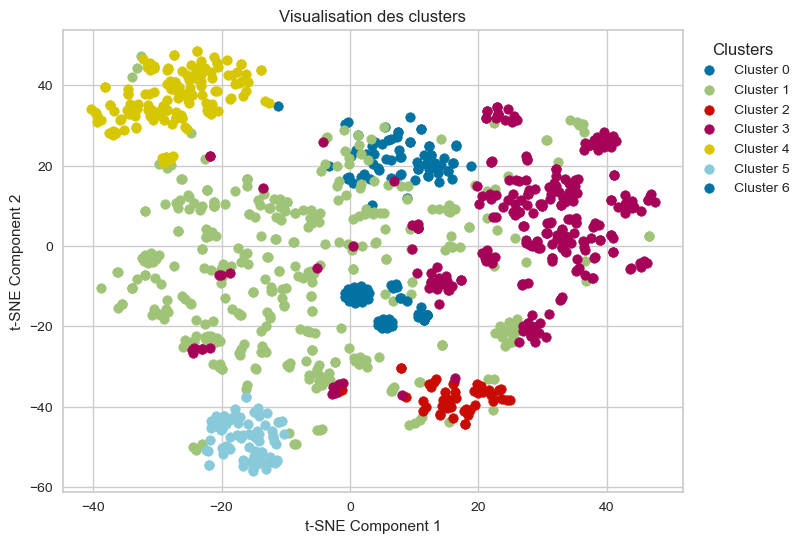

In [61]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Visualize clusters
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(
        X_tsne[cluster_labels == i, 0],
        X_tsne[cluster_labels == i, 1],
        label=f"Cluster {i}",
    )
plt.title("Visualisation des clusters")
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
plt.show()

#### ARI score of categories vs USE clusters 

In [62]:
ari = adjusted_rand_score(df['category'], cluster_labels)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.2434601919101736


In [63]:
from gensim.models import Word2Vec
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings 
warnings.filterwarnings(action='ignore')

In [64]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df_t['category_encoded'] = label_encoder.fit_transform(df_t['category'])


In [65]:
model1 = gensim.models.Word2Vec(df_t.lemmatize_joined, min_count=1,
                                vector_size=100, window=5)

In [66]:
# Creating a list of sentences from df_image['lemmatized']
sentences = df_t.lemmatize_joined.tolist()

# Training the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Empty list to store sentence vectors
sentence_vectors = []

# Iterating through each sentence
for sentence in sentences:
    sentence_vector = []
    # Iterating through each word in the sentence and getting its vector
    for word in sentence:
        if word in model.wv:
            sentence_vector.append(model.wv[word])
    # Calculating the mean vector of the sentence
    if sentence_vector:
        mean_vector = np.mean(sentence_vector, axis=0)
        sentence_vectors.append(mean_vector)

# Creating a DataFrame from the sentence vectors
df_sentence_vectors = pd.DataFrame(sentence_vectors, index=df_t['lemmatize_joined'], columns=[f'feature_{i+1}' for i in range(100)])


In [67]:
len(df_sentence_vectors)

1048

In [68]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the word_vectors_df
tsne_result_wv = tsne.fit_transform(df_sentence_vectors)

# Create a new DataFrame for the t-SNE results
df_tsne_wv = pd.DataFrame(data = tsne_result_wv, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

In [69]:
df_tsne_wv

,TSNE1,TSNE2
0,12.064770,-11.697294
1,37.493954,6.633954
2,11.215174,5.074840
3,7.405483,18.591103
4,6.214761,18.462986
...,...,...
1043,10.598615,-7.943954
1044,2.494194,8.358291
1045,-10.236969,-14.699136
1046,-14.826094,-6.542044


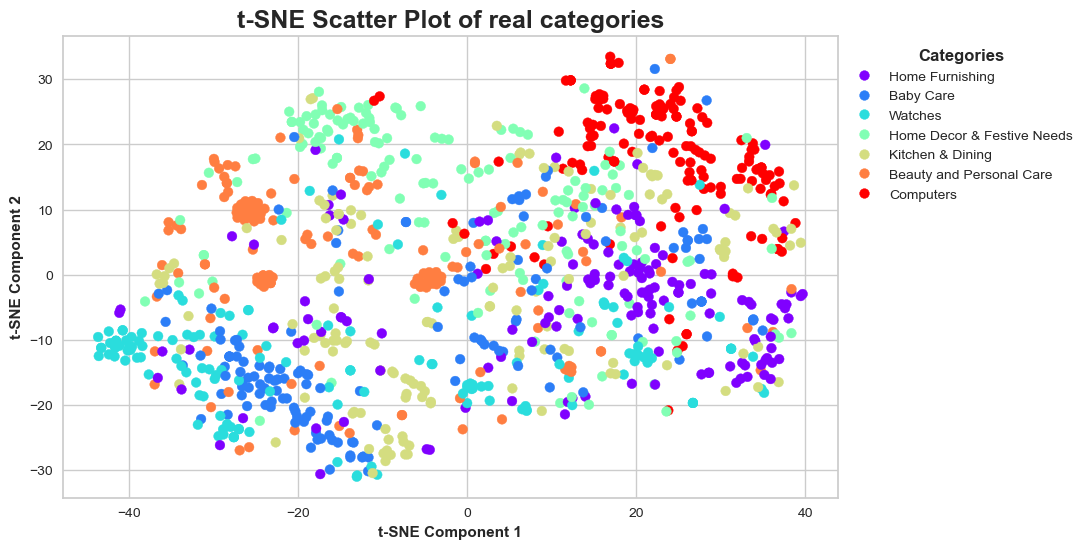

In [70]:
# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_tsne_wv['TSNE1'], df_tsne_wv['TSNE2'], c=df_t['category_encoded'], cmap='rainbow')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_t['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('t-SNE Component 1', fontweight = 'bold')
plt.ylabel('t-SNE Component 2', fontweight = 'bold')
plt.title('t-SNE Scatter Plot of real categories', fontweight ='bold', fontsize=18)
plt.show()

#### Kmeans clustering and visual representation of the t-SNE on Word2Vec 

In [71]:
import random

In [72]:
# kMeans on the t-SNE components
n_clusters = 7  
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(df_tsne_wv[['TSNE1', 'TSNE2']])

# Retrieve cluster labels 
cluster_labels_wv = kmeans.labels_

# Converting to df
df_tsne_wv['Cluster'] = cluster_labels_wv

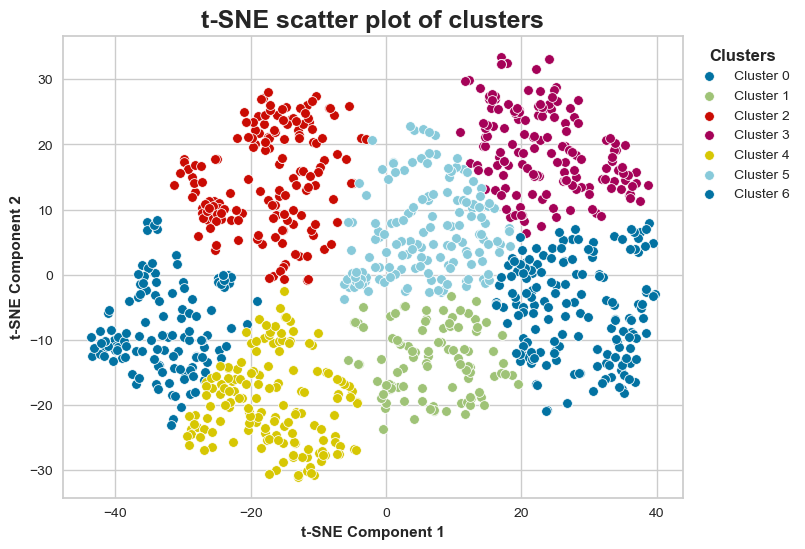

In [73]:
# Plot with a different color for each cluster 
#colors = random_colors(7) # Randomly selects 7 colors for the graph 

plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(cluster_labels_wv)):
    cluster_indices = np.where(cluster_labels_wv == label)
    sns.scatterplot(data=df_tsne_wv.loc[cluster_indices], x='TSNE1', y='TSNE2', label=f'Cluster {label}')

# Adding details 
plt.xlabel('t-SNE Component 1', fontweight ='bold')
plt.ylabel('t-SNE Component 2', fontweight ='bold')
plt.title('t-SNE scatter plot of clusters', fontweight ='bold', fontsize=18)

# Moving the legend outside of the graph
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
legend = plt.gca().get_legend()
legend.get_title().set_fontweight('bold')

plt.show()

In [74]:
ari = adjusted_rand_score(df_t['category'], cluster_labels_wv)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.1750380731043763


### BERT 

In [101]:
import torch

In [102]:
# Setting the device to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Setting the model to evaluation mode
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [103]:
# Function to encode the text using the tokenizer
def get_bert_embeddings(text):
    encoded_input = tokenizer(text, padding = True, truncation = True, return_tensors = 'pt')
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask = attention_mask)
        
    # Calculating the mean embedding of the last hidden state
    embeddings = outputs.last_hidden_state.mean(dim = 1)
    
    # Converting the embeddings to a list and return
    return embeddings.tolist()[0]

In [104]:
# Applying the function to the lemmatized text
df_bert = df_t['lemmatize_joined'].apply(get_bert_embeddings)

In [105]:
# Transforming to df
df_bert_fin = pd.DataFrame(df_bert)

In [106]:
df_bert_fin

,lemmatize_joined
0,"[0.04804511368274689, 0.046610839664936066, 0...."
1,"[0.18314212560653687, -0.02782324329018593, 0...."
2,"[0.007824835367500782, 0.0022673725616186857, ..."
3,"[0.18816757202148438, -0.03589947521686554, 0...."
4,"[0.25443196296691895, 0.02988302707672119, 0.6..."
...,...
1045,"[-0.12494365870952606, 0.2245059758424759, 0.5..."
1046,"[-0.3881279528141022, 0.0947309136390686, 0.59..."
1047,"[0.19897940754890442, -0.1123645231127739, 0.4..."
1048,"[0.05565405637025833, -0.03943667933344841, 0...."


In [108]:
# Transforming to a list
df_bert_list = pd.DataFrame(df_bert_fin['lemmatize_joined'].to_list())

# Splitting the values within the columns using comma delimiter
df_bert_conc = pd.concat([df_bert_list[col].astype(str).str.split(',', expand=True) for col in df_bert_list.columns], axis=1)

# Renaming columns starting from 0
df_bert_conc.columns = [str(i) for i in range(len(df_bert_conc.columns))]

# Displaying the resulting DataFrame with separate columns
df_bert_conc

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.04804511368274689,0.046610839664936066,0.7873408198356628,-0.12329040467739105,0.4309496283531189,0.007683826144784689,0.09294295310974121,0.0586133636534214,-0.019880129024386406,-0.3061487674713135,...,-0.02509152516722679,-0.4458596706390381,0.09960231184959412,0.12727144360542297,0.11184434592723846,0.08268458396196365,-0.36888936161994934,0.022447124123573303,-0.07715581357479095,-0.13652800023555756
1,0.18314212560653687,-0.02782324329018593,0.5348010063171387,0.12005120515823364,0.19718357920646667,0.005752130411565304,0.1744929552078247,-0.0077481321059167385,-0.1438332498073578,-0.16580861806869507,...,-0.037798408418893814,-0.1241784542798996,0.09746749699115753,-0.02511741779744625,0.15218763053417206,0.09989475458860397,-0.37452033162117004,-0.1360265165567398,-0.18188416957855225,0.15960907936096191
2,0.007824835367500782,0.0022673725616186857,0.5762696266174316,-0.03653585910797119,0.31263652443885803,-0.00377508532255888,-0.10784756392240524,0.1831032633781433,-0.13834963738918304,-0.27761560678482056,...,-0.13666260242462158,-0.23302115499973297,0.14451773464679718,0.044191040098667145,0.16111531853675842,0.0901680737733841,-0.46205276250839233,-0.09621627628803253,-0.2085743099451065,0.03215252235531807
3,0.18816757202148438,-0.03589947521686554,0.7175165414810181,0.03351376950740814,0.3220038115978241,-0.23248618841171265,-0.08416551351547241,0.20604532957077026,-0.05749811232089996,-0.0063233403488993645,...,0.10812373459339142,-0.14715039730072021,0.13632744550704956,-0.09044045209884644,0.10717826336622238,0.17352595925331116,-0.4426063895225525,-0.02190212905406952,0.012332340702414513,-0.13386133313179016
4,0.25443196296691895,0.02988302707672119,0.6154786348342896,-0.08420141041278839,0.3025406301021576,-0.18655537068843842,-0.017988743260502815,0.2989371120929718,0.06491528451442719,-0.11216564476490021,...,0.07192430645227432,-0.24966850876808167,0.19995726644992828,0.020121267065405846,-0.001570894499309361,0.12087883055210114,-0.5629705190658569,0.02269718050956726,-0.002450201427564025,-0.13916899263858795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,-0.12494365870952606,0.2245059758424759,0.5290270447731018,-0.24495460093021393,0.5421457290649414,-0.25958842039108276,0.07284571975469589,0.1775914877653122,0.11515384167432785,-0.20280544459819794,...,-0.35391008853912354,-0.39847052097320557,0.029629714787006378,0.25875604152679443,0.17134885489940643,-0.0071940189227461815,-0.5263594388961792,0.025801552459597588,-0.12162918597459793,0.05164889991283417
1044,-0.3881279528141022,0.0947309136390686,0.5905271768569946,-0.09127460420131683,0.43021684885025024,-0.2671785354614258,0.07687202841043472,0.23494316637516022,0.2785288393497467,-0.13544827699661255,...,-0.19953598082065582,-0.3414401113986969,0.045543357729911804,0.23730921745300293,-0.005389007274061441,-0.10120850056409836,-0.3924274444580078,0.013136238791048527,-0.11378566920757294,-0.19826146960258484
1045,0.19897940754890442,-0.1123645231127739,0.43280264735221863,0.08352876454591751,0.35356226563453674,-0.21194355189800262,-0.1824338734149933,0.5244327187538147,-0.18345008790493011,-0.042359355837106705,...,0.0016245096921920776,-0.4650023877620697,0.13862130045890808,0.006051506847143173,0.1336928904056549,-0.012780305929481983,-0.4313761293888092,0.05769456923007965,-0.045955248177051544,-0.1787092685699463
1046,0.05565405637025833,-0.03943667933344841,0.44159039855003357,0.12322184443473816,0.26278361678123474,-0.27610570192337036,-0.008135638199746609,0.28833839297294617,0.08566761016845703,-0.1690397560596466,...,0.0157596617937088,-0.5979921221733093,0.2989043593406677,-0.11364637315273285,0.15752452611923218,-0.23682673275470734,-0.5113663673400879,0.2509691119194031,-0.03593527525663376,-0.42000511288642883


#### T-SNE on BERT 

In [109]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the df_tfidf
tsne_result_bert = tsne.fit_transform(df_bert_conc)

# Creating a new df for the results
df_tsne_bert = pd.DataFrame(data = tsne_result_bert, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

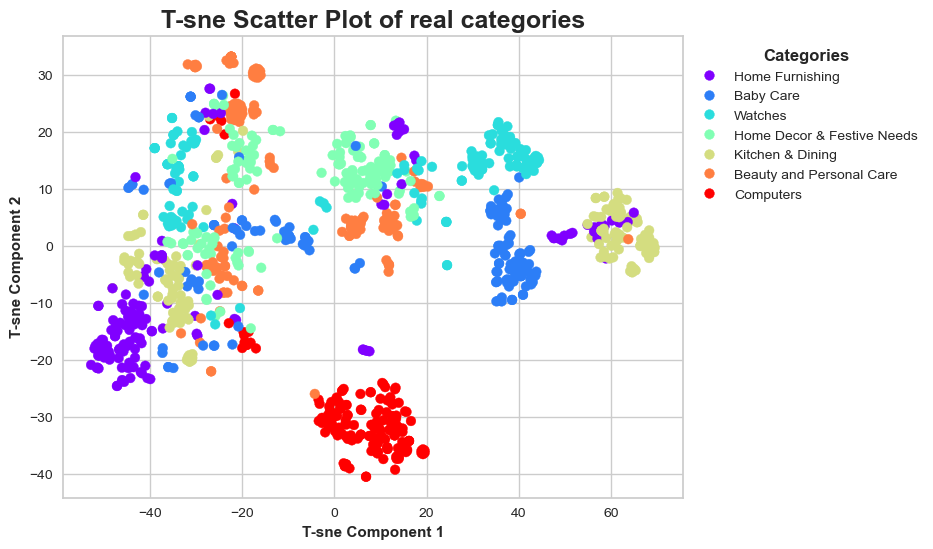

In [132]:
# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_tsne_bert['TSNE1'], df_tsne_bert['TSNE2'], c=df_t['category_encoded'], cmap='rainbow')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_t['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight = 'bold')
plt.ylabel('T-sne Component 2', fontweight = 'bold')
plt.title('T-sne Scatter Plot of real categories', fontweight ='bold', fontsize=18)
plt.show()

#### Kmeans clustering and visual representation of the t-SNE on BERT

In [111]:
# kMeans on the t-SNE components
n_clusters = 7  
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(df_tsne_bert[['TSNE1', 'TSNE2']])

# Retrieving cluster labels 
cluster_labels_bert = kmeans.labels_

# Converting to df
df_tsne_bert['Cluster'] = cluster_labels_bert

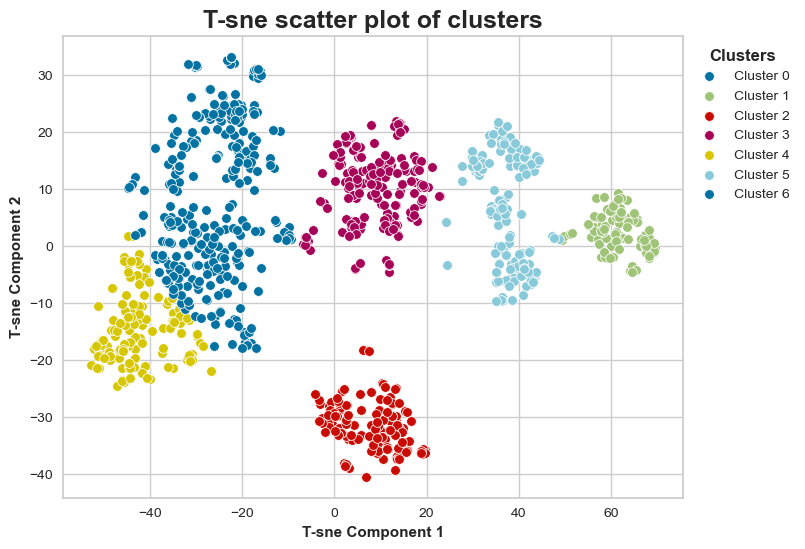

In [131]:
# Plot with a different color for each cluster 

plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(cluster_labels_bert)):
    cluster_indices = np.where(cluster_labels_bert == label)
    sns.scatterplot(data=df_tsne_bert.loc[cluster_indices], x='TSNE1', y='TSNE2', label=f'Cluster {label}')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight ='bold')
plt.ylabel('T-sne Component 2', fontweight ='bold')
plt.title('T-sne scatter plot of clusters', fontweight ='bold', fontsize=18)

# Moving the legend outside of the graph
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
legend = plt.gca().get_legend()
legend.get_title().set_fontweight('bold')

plt.show()

#### ARI scores of real categories vs BERT 

In [114]:
ari = adjusted_rand_score(df_t['category'], cluster_labels_bert)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.31779734281214445


### USE (Universal Sentence Encoder)

  Obtaining dependency information for tensorflow_hub from https://files.pythonhosted.org/packages/6e/1a/fbae76f4057b9bcdf9468025d7a8ca952dec14bfafb9fc0b1e4244ce212f/tensorflow_hub-0.15.0-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/85.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/85.4 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.4 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/85.4 kB ? eta -:--:--
   -------------- ------------------------- 30.7/85.4 kB 220.2 kB/s eta 0:00:01
   -------------- ------------------------- 30.7/85.4 kB 220.2 kB/s eta 0:00:01
   ------------------- -------------------- 41.0/85.4 kB 196.9 kB/s eta 0:00:01
   -------------------------------------- - 81.9/85.4 kB 328.8 kB/s eta 0:00:01
   ---------------------------------------- 85.4/85.4 kB 321.3 kB/s eta 0:00:00


In [119]:
#Converting each sequence of words into a single string
sentences = df_t['lemmatize_joined'].apply(' '.join).values.astype('U')

# Getting and loading the URL for the USE model
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
use_model = hub.load(module_url)

# Creating a KerasLayer fro mthe loaded model
embedding_fn = hub.KerasLayer(use_model, input_shape=[], dtype=tf.string, trainable=False)

# Creating a sequential model with the embedding layer
embedding_model = tf.keras.Sequential([embedding_fn])

# Converting the sentences to a numpy array
sentences_array = np.array(sentences, dtype=object) 

# Generating the sentences with the embedding model
embeddings = embedding_model.predict(sentences_array)

# Transforming to df
embedding_df = pd.DataFrame(embeddings)

33/33 [==============================] - 1471s 45s/step


In [120]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.033529,0.005593,-0.033619,-0.019755,0.031313,0.052536,-0.018704,-0.045935,0.049436,0.006521,...,-0.004326,0.051562,0.043402,0.026941,-0.026880,-0.121074,0.035770,0.030475,0.007476,0.024988
1,-0.032931,-0.014672,-0.022670,0.030195,0.019436,0.043736,-0.004194,-0.075259,0.032070,0.010786,...,-0.012312,0.008845,0.030894,-0.015897,-0.045434,-0.107823,0.021592,0.024653,0.018462,0.021780
2,-0.038978,-0.002425,-0.021920,-0.014565,0.032739,0.053969,-0.021076,-0.048443,0.039901,0.009252,...,0.000215,0.041267,0.047461,0.023206,-0.029807,-0.113523,0.036356,0.034544,0.004563,0.015400
3,-0.032347,-0.016947,-0.025589,-0.010472,0.037240,0.067427,-0.020840,-0.054699,0.034560,0.015550,...,0.000262,0.026612,0.044138,0.010537,-0.039083,-0.118177,0.039734,0.032643,-0.001159,0.022624
4,-0.027723,-0.001744,-0.026327,-0.016045,0.038618,0.072632,-0.014721,-0.045618,0.042509,0.016353,...,-0.000673,0.040620,0.049864,0.019722,-0.031806,-0.114381,0.038945,0.036833,-0.001436,0.024166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,-0.032282,0.006135,-0.029129,-0.020111,0.016617,0.051452,-0.035046,-0.048416,0.041442,0.010120,...,-0.011877,0.062242,0.045373,0.023506,-0.029913,-0.113927,0.036121,0.032095,0.001256,0.032049
1044,-0.036440,0.002581,-0.026254,-0.027388,0.025824,0.045920,-0.018971,-0.043861,0.036792,0.005104,...,-0.006930,0.047469,0.045476,0.026839,-0.027651,-0.125578,0.035495,0.033867,0.012300,0.014856
1045,-0.038190,0.007773,-0.019618,0.034748,-0.003226,0.021599,-0.014132,-0.063171,0.017169,0.001429,...,-0.022366,-0.009080,0.023328,-0.009145,-0.065563,-0.089140,0.009566,0.000837,0.022488,0.011840
1046,-0.024200,0.000890,-0.022662,0.031434,-0.007697,0.011863,-0.000972,-0.059537,0.012374,-0.009132,...,-0.036260,-0.010704,0.028996,-0.013810,-0.061179,-0.102083,0.016745,0.018931,0.031388,0.003283


#### t-SNE on USE 

In [121]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the df_tfidf
tsne_result_use = tsne.fit_transform(embedding_df)

# Create a new DataFrame for the t-SNE results
df_tsne_use = pd.DataFrame(data = tsne_result_use, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

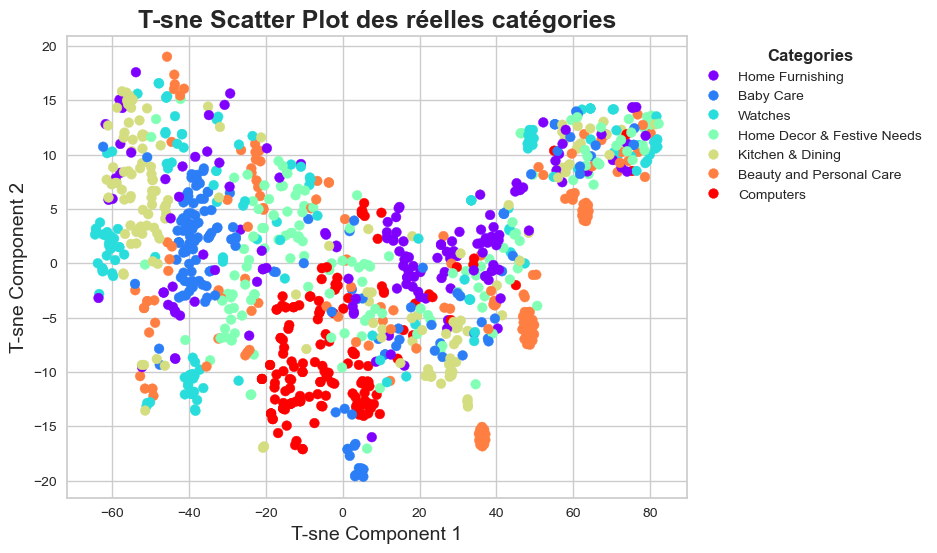

In [129]:
# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_tsne_use['TSNE1'], df_tsne_use['TSNE2'], c=df_t['category_encoded'], cmap='rainbow')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_t['category'].unique(), title='Categories', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('T-sne Component 1', fontsize=14)
plt.ylabel('T-sne Component 2', fontsize=14)
plt.title('T-sne Scatter Plot des réelles catégories', fontweight ='bold', fontsize=18)
plt.show()

#### Kmeans clustering and visual representation of the t-SNE on USE

In [123]:
# kMeans on the t-SNE components
n_clusters = 7  
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(df_tsne_use[['TSNE1', 'TSNE2']])

# Retrieve cluster labels 
cluster_labels_use = kmeans.labels_

# Converting to df
df_tsne_use['Cluster'] = cluster_labels_use

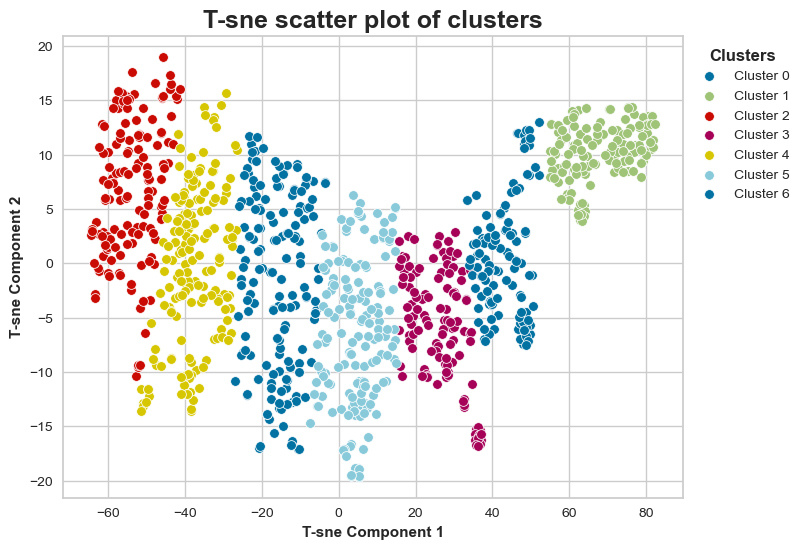

In [130]:
# Plot with a different color for each cluster 


plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(cluster_labels_use)):
    cluster_indices = np.where(cluster_labels_use == label)
    sns.scatterplot(data=df_tsne_use.loc[cluster_indices], x='TSNE1', y='TSNE2', label=f'Cluster {label}')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight ='bold')
plt.ylabel('T-sne Component 2', fontweight ='bold')
plt.title('T-sne scatter plot of clusters', fontweight ='bold', fontsize=18)

# Moving the legend outside of the graph
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Clusters')
legend = plt.gca().get_legend()
legend.get_title().set_fontweight('bold')

plt.show()

#### ARI score of categories vs USE clusters 

In [126]:
ari = adjusted_rand_score(df_t['category'], cluster_labels_use)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.12229353061333906
